<a href="https://colab.research.google.com/github/Gops03/TEORIA_DE_SE-ALES/blob/main/PSDPRUEBAUMBRAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# Librerías para procesamiento de señales
from scipy.signal import welch, find_peaks
from scipy.fft import fft, ifft

# Librerías para creación y entrenamiento de modelos de redes neuronales
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K

# Librerías para visualización
import matplotlib.pyplot as plt
# Librerías para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

In [ ]:


# Función de generación de señal
def señal_generada(fs, f1, f2, f3, A1, A2, A3, t):
    wo = 2 * np.pi
    return A1 * np.cos(wo * f1 * t) + A2 * np.sin(wo * f2 * t) + A3 * np.cos(wo * f3 * t)

# Función para generar datos ruidosos y sus PSD correspondientes
def generar_datos(signal, fs, sigma, num_samples=1000):
    X, y = [], []
    for _ in range(num_samples):
        noise = np.random.normal(0, sigma, signal.shape)
        noisy_signal = signal + noise
        X.append(noisy_signal)
        f, Pxx = welch(noisy_signal, fs, nperseg=256)
        y.append(Pxx)
    return np.array(X), np.array(y)

# Función para graficar la curva de pérdida y validación
def grafica_perdida(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Curva de pérdida')
    plt.plot(history.history['val_loss'], label='Curva de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Evolución de la Curva de pérdida')
    plt.tight_layout()
    plt.show()

# Función para comparar la PSD original y la predicha
def comparacion_psd(y_pred, f_original, Pxx_original):
    plt.figure(figsize=(10, 6))
    plt.semilogy(f_original, Pxx_original, label='PSD Original')
    plt.semilogy(f_original, y_pred[0], label='PSD Predicha')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad Espectral de Potencia (PSD)')
    plt.title('Comparación de la PSD Original y Predicha')
    plt.legend()
    plt.grid(True)
    plt.show()

# Función para crear un histograma de los armónicos
def histograma_armonicos(fh1, fh2, fh3, f_original, y_pred):
    harmonic_frequencies = [fh1, fh2, fh3]
    harmonic_indices = [np.argmin(np.abs(f_original - freq)) for freq in harmonic_frequencies]

    power_harmonics = [[] for _ in range(3)]
    for psd in y_pred:
        for i in range(3):
            power_harmonics[i].append(psd[harmonic_indices[i]])

    plt.figure(figsize=(18, 6))
    titles = ['Armónico 1 (100 Hz)', 'Armónico 2 (200 Hz)', 'Armónico 3 (400 Hz)']
    colors = ['blue', 'green', 'red']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.hist(power_harmonics[i], bins=30, color=colors[i], alpha=0.7)
        plt.title(titles[i])
        plt.xlabel('Potencia')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)

    plt.tight_layout(pad=2.0)
    plt.show()

# Función para definir un umbral y detectar picos en la PSD
def calcular_umbral(X_test, fs, sigma, errores):
    frecuencias_reales = [100, 200, 400]
    f, Pxx = welch(X_test[0], fs, nperseg=256)

    hist, bin_edges = np.histogram(Pxx, bins=50, density=True)
    cumulative_density = np.cumsum(hist * np.diff(bin_edges))
    threshold_index = np.where(cumulative_density >= 0.95)[0][0]
    threshold_value = bin_edges[threshold_index]

    peaks, _ = find_peaks(Pxx, height=threshold_value)
    total_detected = len(peaks)
    correct_detections = sum(1 for peak in peaks if any(abs(f[peak] - freq) <= 10 for freq in frecuencias_reales))
    error_percentage = ((total_detected - correct_detections) / total_detected) * 100 if total_detected > 0 else 0

    errores.append({'Sigma': sigma, 'Error': error_percentage})

    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx, label='PSD Señal')
    plt.semilogy(f[peaks], Pxx[peaks], 'rx', label='Picos Identificados')
    plt.axhline(y=threshold_value, color='green', linestyle='--', label=f'Umbral (95% Histograma): {threshold_value:.3e} V^2/Hz')
    plt.title('Densidad Espectral de Potencia (PSD)')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad Espectral de Potencia (V^2/Hz)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Función para reconstruir la señal original a partir de la PSD predicha
def señal_reconstruida(X_test, y_pred, fs, t):
    fft_signal = fft(X_test[0])
    magnitude_original = np.abs(fft_signal)
    phase_original = np.angle(fft_signal)

    magnitude_pred = np.sqrt(y_pred[0] * fs)
    magnitude_pred_full = np.concatenate([magnitude_pred, magnitude_pred[::-1][1:]])

    fft_reconstructed = magnitude_pred_full * np.exp(1j * phase_original)
    reconstructed_signal = np.real(ifft(fft_reconstructed))

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, X_test[0], label='Señal Original', color='blue')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Señal Original')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, reconstructed_signal, label='Señal Reconstruida', color='orange')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Señal Reconstruida')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Definir las métricas de error
def mse(original, predicha):
    return np.mean((original - predicha) ** 2)

def mae(original, predicha):
    return np.mean(np.abs(original - predicha))

def rmse(original, predicha):
    return np.sqrt(np.mean((original - predicha) ** 2))

def l1_error(original, predicha):
    return np.sum(np.abs(original - predicha))

def l2_error(original, predicha):
    return np.sqrt(np.sum(np.square(original - predicha)))

# Calcular las métricas de error
def calcular_errores(y_test, y_pred):
    return {
        'MSE_Test': mse(y_test, y_pred),
        'MAE_Test': mae(y_test, y_pred),
        'RMSE_Test': rmse(y_test, y_pred),
        'L1_Test': l1_error(y_test, y_pred),
        'L2_Test': l2_error(y_test, y_pred)
    }

# Función para graficar todas las métricas de error juntas
def graficar_metricas_de_prueba_juntas(df_resultados):
    plt.figure(figsize=(12, 8))

    # Colores para cada métrica
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    labels = ['MSE (Prueba)', 'MAE (Prueba)', 'RMSE (Prueba)', 'L1 (Prueba)', 'L2 (Prueba)']

    for i, col in enumerate(df_resultados.columns[1:]):
        plt.plot(df_resultados['Sigma'], df_resultados[col], marker='o', label=labels[i], color=colors[i])

    plt.title('Métricas de Error (Prueba)')
    plt.xlabel('Sigma')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar error porcentual en función de sigma
def graficar_error_porcentual(df_errores):
    plt.figure(figsize=(10, 6))
    plt.plot(df_errores['Sigma'], df_errores['Error'], marker='o', color='red')
    plt.xlabel('Sigma')
    plt.ylabel('Error porcentual (%)')
    plt.title('Sigma vs Error porcentual')
    plt.grid(True)
    plt.xticks(df_errores['Sigma'])
    plt.xlim([min(df_errores['Sigma']) - 1, max(df_errores['Sigma']) + 1])
    plt.show()


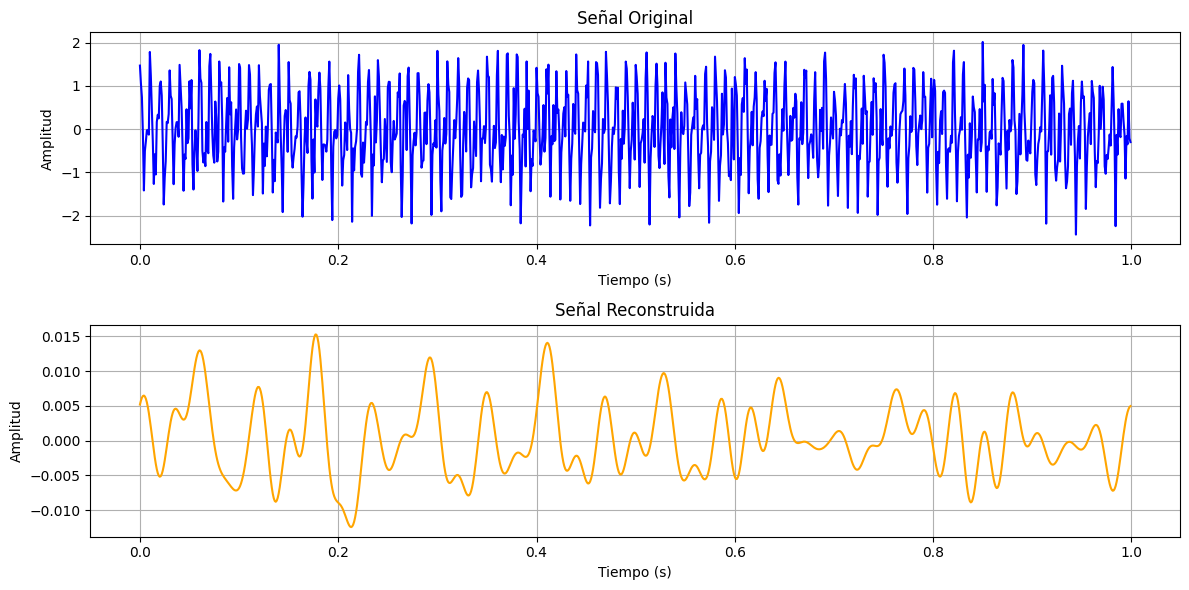

In [ ]:
import numpy as np
from scipy.fft import fft, ifft

# Realizar la FFT sobre la señal original
fft_signal = fft(X_test[0])

# Tomar la magnitud y fase original
magnitude_original = np.abs(fft_signal)
phase_original = np.angle(fft_signal)

# Utilizar la PSD predicha para obtener la magnitud predicha
magnitude_pred = np.sqrt(y_pred[0] * fs)

# Expandir la magnitud predicha para cubrir todo el espectro
# Rellenar con ceros en la frecuencia media y las negativas
magnitude_pred_full = np.zeros_like(magnitude_original)
half_length = len(magnitude_pred)
magnitude_pred_full[:half_length] = magnitude_pred  # Primeros N/2 valores
magnitude_pred_full[-half_length+1:] = magnitude_pred[1:][::-1]  # Espejo de la parte positiva

# Reconstruir la señal usando la magnitud predicha y la fase original
fft_reconstructed = magnitude_pred_full * np.exp(1j * phase_original)
reconstructed_signal = np.real(ifft(fft_reconstructed))

# Seleccionar solo una parte de la señal para graficar
start, end = 0, 1000  # Puedes ajustar estos valores según lo que quieras visualizar

# Crear los gráficos en subplots separados
plt.figure(figsize=(12, 6))

# Gráfico de la señal original
plt.subplot(2, 1, 1)
plt.plot(t[start:end], X_test[0][start:end], label='Señal Original', color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Original')
plt.grid(True)

# Gráfico de la señal reconstruida
plt.subplot(2, 1, 2)
plt.plot(t[start:end], reconstructed_signal[start:end], label='Señal Reconstruida', color='orange')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Reconstruida')
plt.grid(True)

plt.tight_layout()
plt.show()


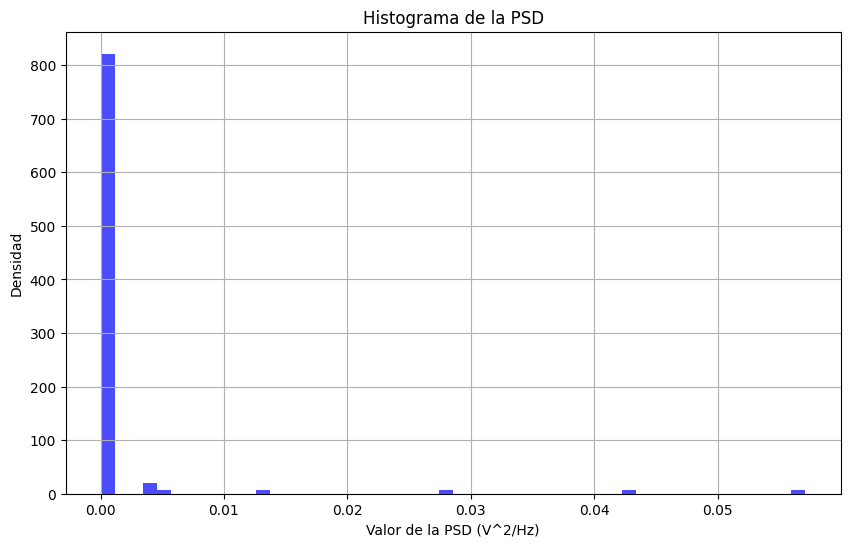

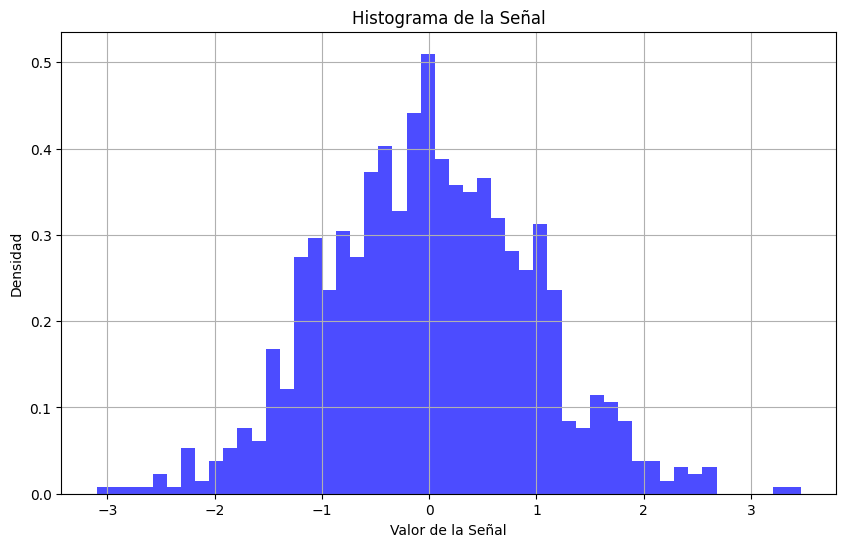

In [ ]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

# Asumiendo que 'X_test[0]' es la señal que estamos analizando y 'fs' es la frecuencia de muestreo

# Calcular la PSD de la señal
f, Pxx = welch(X_test[0], fs, nperseg=256)

# Calcular el histograma de los valores de la PSD
hist, bin_edges = np.histogram(Pxx, bins=50, density=True)

# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(Pxx, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Histograma de la PSD')
plt.xlabel('Valor de la PSD (V^2/Hz)')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

# Supongamos que 'signal' es la señal cuya distribución queremos analizar
# Para este ejemplo, voy a generar una señal de muestra
signal = np.random.randn(1000)  # Señal de ejemplo: 1000 valores aleatorios de una distribución normal

# Calcular el histograma
hist, bin_edges = np.histogram(signal, bins=20, density=True)

# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(signal, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Histograma de la Señal')
plt.xlabel('Valor de la Señal')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()


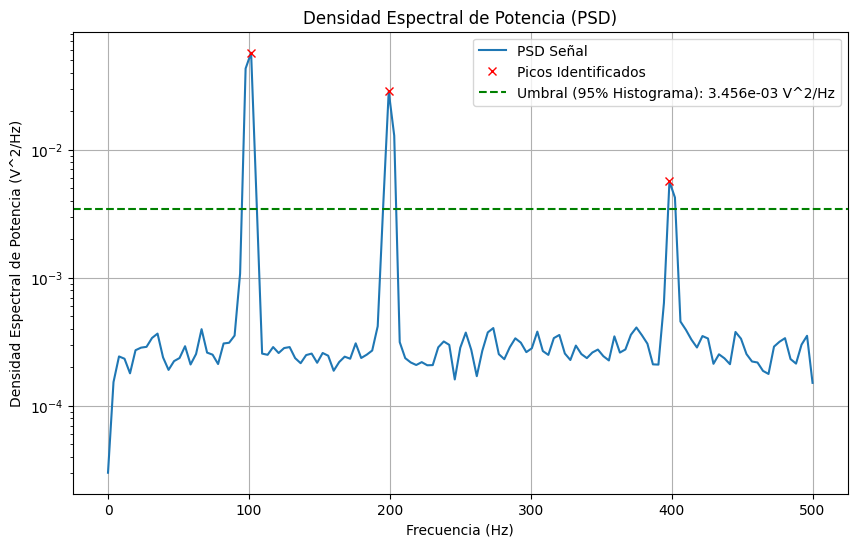

In [ ]:
import numpy as np
from scipy.signal import welch, find_peaks
import matplotlib.pyplot as plt

# Asumiendo que 'X_test[0]' es la señal que estamos analizando y 'fs' es la frecuencia de muestreo

# Calcular la PSD de la señal
f, Pxx = welch(X_test[0], fs, nperseg=256)

# Calcular el histograma de los valores de la PSD
hist, bin_edges = np.histogram(Pxx, bins=50, density=True)

# Calcular la densidad acumulada
cumulative_density = np.cumsum(hist * np.diff(bin_edges))

# Definir un umbral en términos de la densidad acumulada, por ejemplo, el 95%
threshold_density = 0.95
threshold_index = np.where(cumulative_density >= threshold_density)[0][0]
threshold_value = bin_edges[threshold_index]

# Encontrar los picos más prominentes en la PSD usando el umbral calculado
peaks, _ = find_peaks(Pxx, height=threshold_value)

# Graficar la PSD
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx, label='PSD Señal')
plt.semilogy(f[peaks], Pxx[peaks], 'rx', label='Picos Identificados')
plt.axhline(y=threshold_value, color='green', linestyle='--', label=f'Umbral (95% Histograma): {threshold_value:.3e} V^2/Hz')
plt.title('Densidad Espectral de Potencia (PSD)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral de Potencia (V^2/Hz)')
plt.legend()
plt.grid(True)
plt.show()


Entrenando modelo con sigma = 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Entrenando modelo con sigma = 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Entrenando modelo con sigma = 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Entrenando modelo con sigma = 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Entrenando modelo con sigma = 10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Entrenando modelo con sigma = 30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Tabla de Reconstrucción y Rendimiento:
--------------------------------------
 Sigma  MSE Entrenamiento  MAE Entrenamiento  RMSE Entrenamiento  L2 Entrenamiento  MSE Prueba  MAE Prueba  RMSE Prueba  L2 Prueba
   0.1           0.900453           0.756831            0.948922        600.150900    0.960441    0.781731     0.980021 277.191771

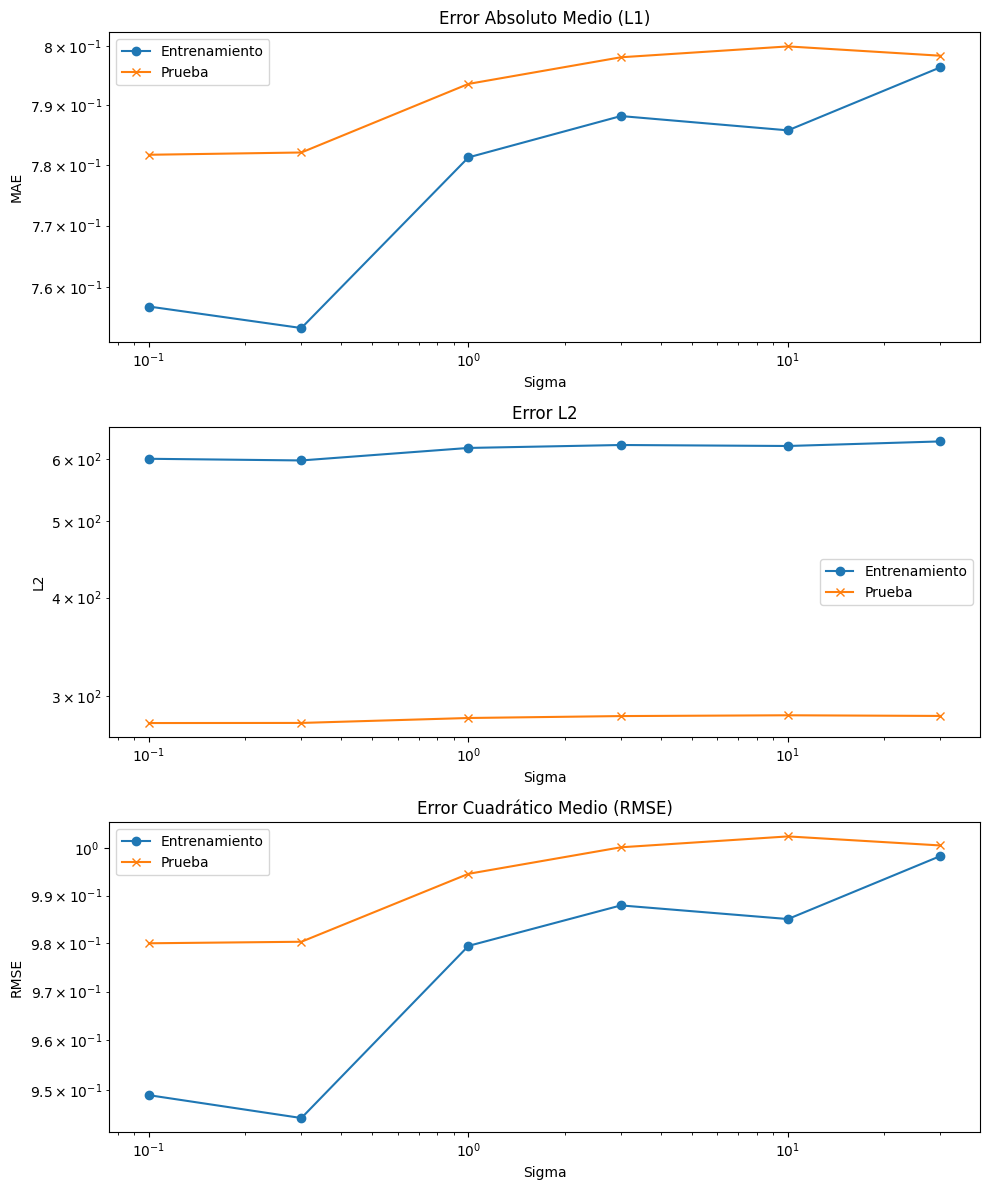

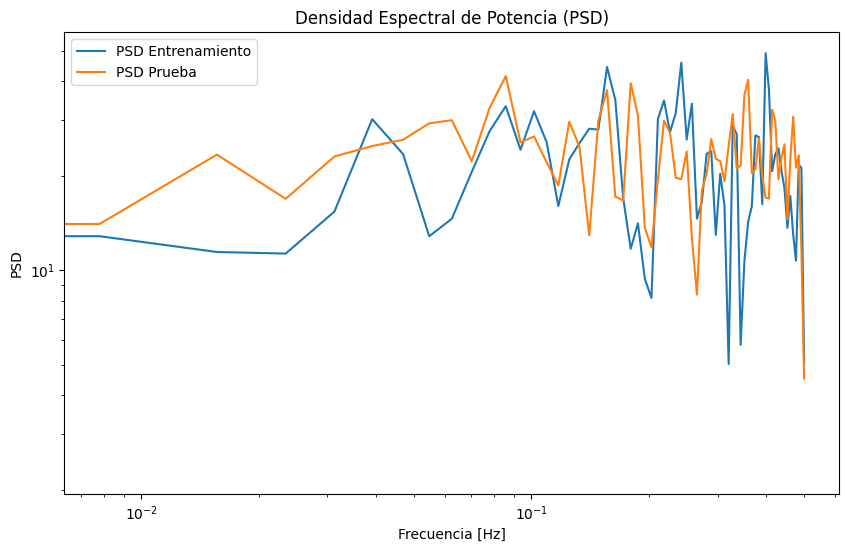

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.signal import welch

# Definir las métricas de error
def mse(original, reconstruida):
    return np.mean((original - reconstruida) ** 2)

def mae(original, reconstruida):
    return np.mean(np.abs(original - reconstruida))

def rmse(original, reconstruida):
    return np.sqrt(np.mean((original - reconstruida) ** 2))

def l2_error(original, reconstruida):
    return np.linalg.norm(original - reconstruida)

# Función para agregar ruido a una señal
def add_noise(signal, sigma):
    noise = np.random.normal(0, sigma, signal.shape)
    return signal + noise

# Ejemplo de datos
np.random.seed(0)  # Para reproducibilidad de la señal base, no del ruido posterior
X_train = np.random.randn(1000, 400)  # Datos de entrenamiento simulados
X_test = np.random.randn(200, 400)    # Datos de prueba simulados

# Lista de diferentes niveles de sigma para el ruido
sigma_values = [0.1, 0.3, 1, 3, 10, 30]

# Resultados para almacenar las métricas
results = []

# Iterar sobre cada valor de sigma
for sigma in sigma_values:
    print(f"Entrenando modelo con sigma = {sigma}")

    # Generar señales ruidosas
    X_train_noisy = np.array([add_noise(x, sigma) for x in X_train])
    X_test_noisy = np.array([add_noise(x, sigma) for x in X_test])

    # Crear el modelo de red neuronal
    model = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_noisy.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(X_train_noisy.shape[1], activation='linear')
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Entrenar el modelo con Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train_noisy, X_train, validation_data=(X_test_noisy, X_test), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Reconstruir señales
    reconstructed_signal_train = model.predict(X_train_noisy)
    reconstructed_signal_test = model.predict(X_test_noisy)

    # Calcular las métricas de error
    mse_train = mse(X_train, reconstructed_signal_train)
    mae_train = mae(X_train, reconstructed_signal_train)
    rmse_train = rmse(X_train, reconstructed_signal_train)
    l2_train = l2_error(X_train, reconstructed_signal_train)

    mse_test = mse(X_test, reconstructed_signal_test)
    mae_test = mae(X_test, reconstructed_signal_test)
    rmse_test = rmse(X_test, reconstructed_signal_test)
    l2_test = l2_error(X_test, reconstructed_signal_test)

    # Guardar los resultados
    results.append({
        'Sigma': sigma,
        'MSE Entrenamiento': mse_train,
        'MAE Entrenamiento': mae_train,
        'RMSE Entrenamiento': rmse_train,
        'L2 Entrenamiento': l2_train,
        'MSE Prueba': mse_test,
        'MAE Prueba': mae_test,
        'RMSE Prueba': rmse_test,
        'L2 Prueba': l2_test
    })

# Crear un DataFrame para mostrar los resultados
df_results = pd.DataFrame(results)

# Mostrar la tabla de errores
header = "Tabla de Reconstrucción y Rendimiento:"
separator = "-" * len(header)
table_str = df_results.to_string(index=False)

print(f"\n{header}\n{separator}\n{table_str}")

# Gráficas logarítmicas para L1, L2 y RMSE
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].plot(df_results['Sigma'], df_results['MAE Entrenamiento'], marker='o', label='Entrenamiento')
ax[0].plot(df_results['Sigma'], df_results['MAE Prueba'], marker='x', label='Prueba')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Error Absoluto Medio (L1)')
ax[0].set_xlabel('Sigma')
ax[0].set_ylabel('MAE')
ax[0].legend()

ax[1].plot(df_results['Sigma'], df_results['L2 Entrenamiento'], marker='o', label='Entrenamiento')
ax[1].plot(df_results['Sigma'], df_results['L2 Prueba'], marker='x', label='Prueba')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Error L2')
ax[1].set_xlabel('Sigma')
ax[1].set_ylabel('L2')
ax[1].legend()

ax[2].plot(df_results['Sigma'], df_results['RMSE Entrenamiento'], marker='o', label='Entrenamiento')
ax[2].plot(df_results['Sigma'], df_results['RMSE Prueba'], marker='x', label='Prueba')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Error Cuadrático Medio (RMSE)')
ax[2].set_xlabel('Sigma')
ax[2].set_ylabel('RMSE')
ax[2].legend()

plt.tight_layout()
plt.show()

# Gráfico de Welch para detección de picos y error
plt.figure(figsize=(10, 6))
frequencies, psd_train = welch(X_train_noisy[0], nperseg=128, scaling='spectrum')
frequencies, psd_test = welch(X_test_noisy[0], nperseg=128, scaling='spectrum')
plt.plot(frequencies, psd_train, label='PSD Entrenamiento')
plt.plot(frequencies, psd_test, label='PSD Prueba')
plt.xscale('log')
plt.yscale('log')
plt.title('Densidad Espectral de Potencia (PSD)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD')
plt.legend()
plt.show()


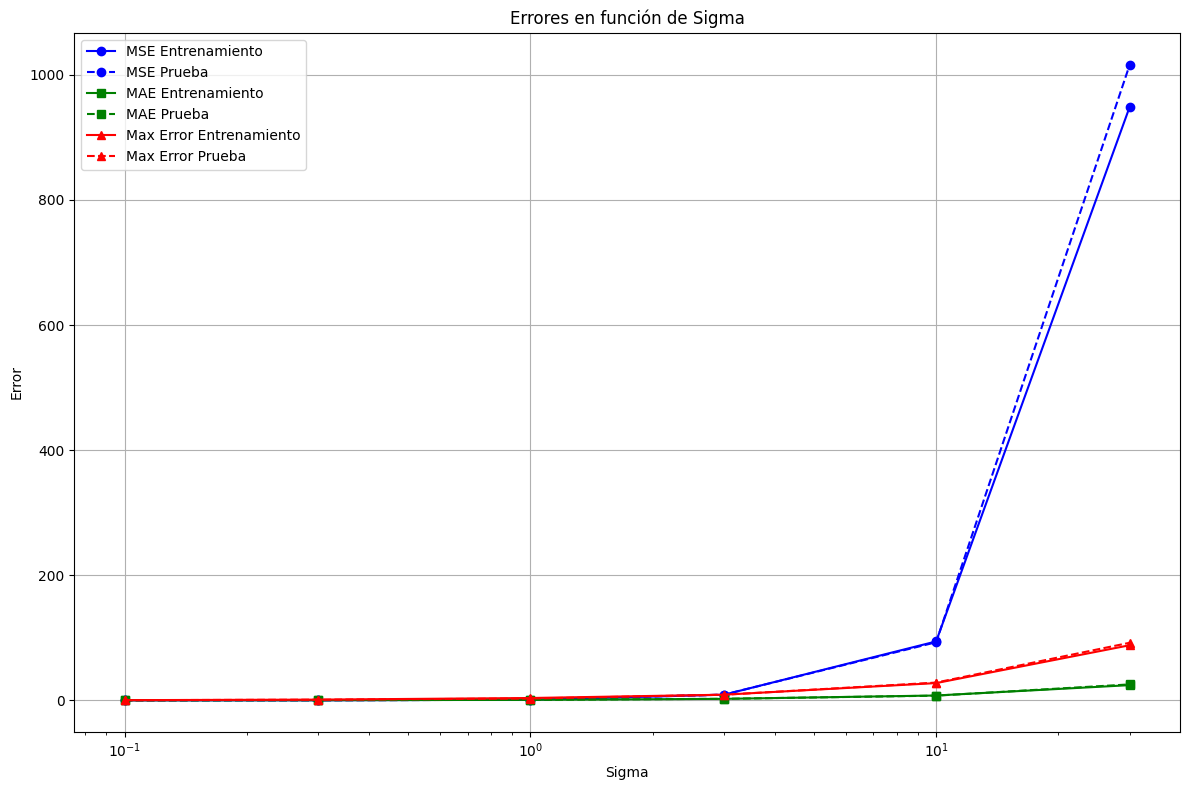

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir las métricas de error
def mse(original, reconstruida):
    return np.mean((original - reconstruida) ** 2)

def mae(original, reconstruida):
    return np.mean(np.abs(original - reconstruida))

def max_error(original, reconstruida):
    return np.max(np.abs(original - reconstruida))

# Función para agregar ruido a una señal
def add_noise(signal, sigma):
    noise = np.random.normal(0, sigma, signal.shape)
    return signal + noise

# Función de reconstrucción simulada (esto debe ser reemplazado por tu lógica real de reconstrucción)
def reconstruct_signal(noisy_signal):
    # Aquí deberías aplicar tu método de reconstrucción real
    return noisy_signal  # Para el ejemplo, solo devolvemos la señal ruidosa

# Ejemplo de datos
np.random.seed(0)  # Para reproducibilidad
X_train = np.random.randn(1, 1000)  # Datos de entrenamiento simulados
X_test = np.random.randn(1, 1000)   # Datos de prueba simulados

# Definir un rango de índices para la evaluación
start = 100
end = 500

# Lista de diferentes niveles de sigma para el ruido
sigma_values = [0.1, 0.3, 1, 3, 10, 30]

# Resultados para almacenar las métricas
results = []

# Iterar sobre cada valor de sigma
for sigma in sigma_values:
    # Generar señales ruidosas
    noisy_signal_train = add_noise(X_train[0][start:end], sigma)
    noisy_signal_test = add_noise(X_test[0][start:end], sigma)

    # Reconstruir señales
    reconstructed_signal_train = reconstruct_signal(noisy_signal_train)
    reconstructed_signal_test = reconstruct_signal(noisy_signal_test)

    # Calcula las métricas de error
    mse_train = mse(X_train[0][start:end], reconstructed_signal_train)
    mae_train = mae(X_train[0][start:end], reconstructed_signal_train)
    max_error_train = max_error(X_train[0][start:end], reconstructed_signal_train)

    mse_test = mse(X_test[0][start:end], reconstructed_signal_test)
    mae_test = mae(X_test[0][start:end], reconstructed_signal_test)
    max_error_test = max_error(X_test[0][start:end], reconstructed_signal_test)

    # Guardar los resultados
    results.append({
        'Sigma': sigma,
        'MSE Entrenamiento': mse_train,
        'MAE Entrenamiento': mae_train,
        'Max Error Entrenamiento': max_error_train,
        'MSE Prueba': mse_test,
        'MAE Prueba': mae_test,
        'Max Error Prueba': max_error_test
    })

# Crear un DataFrame para mostrar los resultados
df_results = pd.DataFrame(results)

# Crear gráficos para cada métrica en un solo gráfico
plt.figure(figsize=(12, 8))

# Graficar MSE
plt.plot(df_results['Sigma'], df_results['MSE Entrenamiento'], marker='o', linestyle='-', color='b', label='MSE Entrenamiento')
plt.plot(df_results['Sigma'], df_results['MSE Prueba'], marker='o', linestyle='--', color='b', label='MSE Prueba')

# Graficar MAE
plt.plot(df_results['Sigma'], df_results['MAE Entrenamiento'], marker='s', linestyle='-', color='g', label='MAE Entrenamiento')
plt.plot(df_results['Sigma'], df_results['MAE Prueba'], marker='s', linestyle='--', color='g', label='MAE Prueba')

# Graficar Max Error
plt.plot(df_results['Sigma'], df_results['Max Error Entrenamiento'], marker='^', linestyle='-', color='r', label='Max Error Entrenamiento')
plt.plot(df_results['Sigma'], df_results['Max Error Prueba'], marker='^', linestyle='--', color='r', label='Max Error Prueba')

# Configuración del gráfico
plt.xscale('log')
plt.xlabel('Sigma')
plt.ylabel('Error')
plt.title('Errores en función de Sigma')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar gráfico
plt.show()
